# B regressor final training

## Import

### Import modules

In [1]:
from __future__ import division, print_function
import random
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K

import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../../modules')
from MPPlot import *
from Processors import *


/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
loc = '../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['260', '270', '280', '300', '320', '400', '500', '550', '600' ,'700']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data X
    Returns: X after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)
    
    return X

data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


### Process data and add new features

In [3]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum


moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [4]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


### Specify variables

In [5]:
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
print(*trainFeatures, sep=' , ')

t_0_pT , t_0_eta , t_0_phi , t_0_mass , t_1_pT , t_1_eta , t_1_phi , t_1_mass , b_0_pT , b_0_eta , b_0_phi , b_0_mass , b_0_csv , b_1_pT , b_1_eta , b_1_phi , b_1_mass , b_1_csv , mPT_pT , mPT_phi , h_tt_pT , h_tt_eta , h_tt_phi , h_tt_mass , h_tt_svFit_mass , h_bb_pT , h_bb_eta , h_bb_phi , h_bb_mass , diH_pT , diH_eta , diH_phi , diH_mass , diH_kinFit_mass , diH_kinFit_prob , mT , hT , sT , centrality , eVis , sphericity , spherocity , aplanarity , aplanority , upsilon , dShape , sphericityEigen0 , sphericityEigen1 , sphericityEigen2 , spherocityEigen0 , spherocityEigen1 , spherocityEigen2 , t_0_px , t_0_py , t_0_pz , t_0_|p| , t_0_E , t_1_px , t_1_py , t_1_pz , t_1_|p| , t_1_E , b_0_px , b_0_py , b_0_pz , b_0_|p| , b_0_E , b_1_px , b_1_py , b_1_pz , b_1_|p| , b_1_E , h_tt_px , h_tt_py , h_tt_pz , h_tt_|p| , h_tt_E , h_bb_px , h_bb_py , h_bb_pz , h_bb_|p| , h_bb_E , diH_px , diH_py , diH_pz , diH_|p| , diH_E , mPT_px , mPT_py , mPT_|p| , t_1_mT , hl_mT


In [6]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]

other = [var for var in trainFeatures for x in ['Fit', 'csv'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi+ other]
print(trainFeatures)

['t_0_mass', 't_1_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_mT']


In [7]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures ]

In [8]:
finalFeatures = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi] + ['hl_mT']
finalFeatures = ['h_bb_mass']
print(finalFeatures)

['h_bb_mass']


## Specify options

In [9]:
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

compileArgs = {'loss':'binary_crossentropy','optimizer':'adam'}

#g = getGenerator(len(finalFeatures))
#d = getDiscriminator(len(finalFeatures))
inputs1 = Input(shape=(1,))
inputs2 = Input(shape=(len(finalFeatures),))

Gx = Dense(20, activation="tanh", bias_initializer='glorot_normal')(inputs1)
Gx = Dense(20, activation="relu", bias_initializer='glorot_normal')(Gx)
Gx = Dense(len(finalFeatures), activation="linear")(Gx)

G = Model(inputs=[inputs1], outputs=[Gx])

Dx = Dense(20, activation="tanh")(inputs2)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)

d = Model(inputs=[inputs2], outputs=[Dx])

D = Model(inputs=[inputs2], outputs=[d(inputs2)])
D.compile(**compileArgs)

temp = d(G(inputs1))

d.trainable = False

A = Model(inputs=[inputs1], outputs=[temp])
A.compile(**compileArgs)

#G = Model(inputs=[inputs1], outputs=g(inputs1))
#G.compile(**compileArgs)

### Preprocess data

In [10]:
normIn = True
pca = True
whiten = False

In [11]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []

In [12]:
X_class = inputPipe.fit_transform(devData[finalFeatures].values.astype(theano.config.floatX))
Y_class = pandas.Series(np.ones(X_class.shape[0]))

### Train regressors
Train nSplit times to find best convergence

In [13]:
batch_size = 512
trainParams = {'batch_size' : batch_size, 'verbose' : 0}

In [14]:
losses = {'D_dev': [], 'D_val': [], 'A_val': [], 'A_dev': [], 'D_ran': []}

In [26]:
for i in range(100):
    print(i, end='\r')
    #get a batch_size of things:
    sample = X_class[np.random.choice(X_class.shape[0], batch_size, replace=False), :]
    
    fakeInput = np.random.normal(size=(batch_size, 1))
    fakeData = G.predict(fakeInput)
    
    labels = np.append(np.ones(batch_size), np.zeros(batch_size))
    data = np.append(sample, fakeData, axis=0)
    
    #training D
        
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
    
    D_hist = D.fit(X_train, y_train, 
                   validation_data = (X_test, y_test),
                   verbose=0)
    
    losses['D_dev'].append(D_hist.history['loss'])
    losses['D_val'].append(D_hist.history['val_loss'])
    
    # training A
    
    X_train, X_test, y_train, y_test = train_test_split(fakeInput, np.ones(len(fakeInput)), test_size=0.33, random_state=42)
    
    A_hist = A.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   verbose=0)
    
    losses['A_dev'].append(A_hist.history['loss'])
    losses['A_val'].append(A_hist.history['val_loss'])
    
    tvar = D.predict(np.random.normal(size=(batch_size, len(finalFeatures))))
    losses['D_ran'].append(sum(tvar)/batch_size)
    

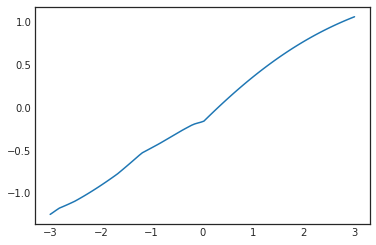

In [27]:
x = np.linspace(-3,3,100)

plt.plot(x, G.predict(x))

#G.predict(np.random.normal(size = (10, 1)))

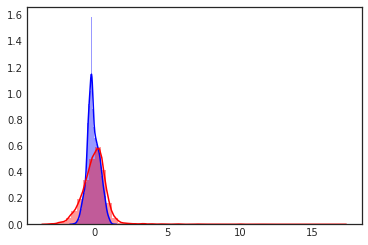

In [28]:
sns.distplot(G.predict(np.random.normal(size = (len(X_class), 1))), color='b')
sns.distplot(X_class, color='r')

plt.show()

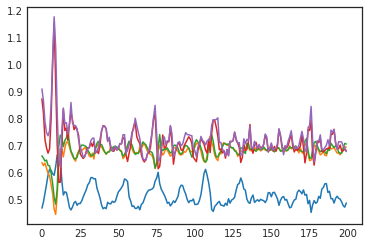

In [29]:
plt.plot(losses['D_ran'])
plt.plot(losses['D_val'])
plt.plot(losses['D_dev'])
plt.plot(losses['A_val'])
plt.plot(losses['A_dev'])

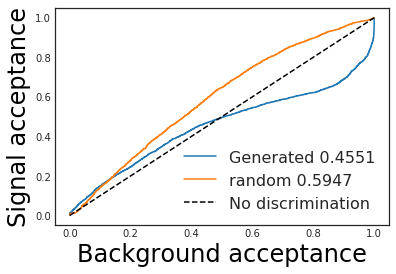

In [30]:
fakeInput = np.random.normal(size=(len(X_class), 1))
fakeData = G.predict(fakeInput)
randomData = np.random.normal(size=(len(X_class), len(finalFeatures)))
    
labels = np.append(np.ones(len(X_class)), np.zeros(len(X_class)))
data1 = np.append(X_class, fakeData, axis=0)
data2 = np.append(X_class, randomData, axis=0)

plt.plot(*roc_curve(labels, D.predict(data1))[:2], label='Generated {:.4f}'.format(roc_auc_score(labels, D.predict(data1))))
plt.plot(*roc_curve(labels, D.predict(data2))[:2], label='random {:.4f}'.format(roc_auc_score(labels, D.predict(data2))))
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)

In [20]:
D.predict(np.random.normal(size=(20,len(finalFeatures))))

array([[ 0.60554242],
       [ 0.4411324 ],
       [ 0.44015595],
       [ 0.46567047],
       [ 0.56860805],
       [ 0.3731221 ],
       [ 0.35045546],
       [ 0.42956612],
       [ 0.58534044],
       [ 0.51627982],
       [ 0.44445595],
       [ 0.49106759],
       [ 0.54737896],
       [ 0.45851353],
       [ 0.52314579],
       [ 0.34932423],
       [ 0.60653657],
       [ 0.52001548],
       [ 0.55892003],
       [ 0.4948346 ]], dtype=float32)